## Here I will attempt to use advanced regression techniques to predict bike rentals. The data set is a part of the following kaggle competition: 
https://www.kaggle.com/c/bike-sharing-demand

I found that applying logarithmic transformations to the dependent variable, as well as generating new time featurers were key to scoring in the top ten percent.

In [1]:



import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer

pd.options.display.max_columns=150
train= pd.read_csv('/Users/maxwalker/Desktop/Kaggle/bike-sharing-demand/train.csv')
holdout= pd.read_csv('/Users/maxwalker/Desktop/Kaggle/bike-sharing-demand/test.csv')

In [2]:
dt = holdout['datetime']

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


---
## Adding date variables

In [4]:
date = pd.DatetimeIndex(train['datetime'])
train['year'], train['month'], train['hour'], train['dayofweek'] = date.year, date.month, date.hour, date.dayofweek
train.drop(columns='datetime', inplace=True)

In [5]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4,5


---
## Investigating and transforming the y variable

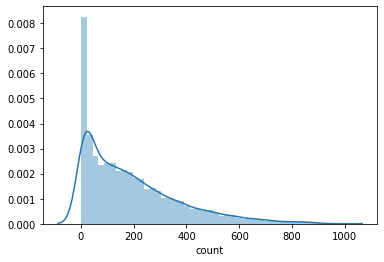

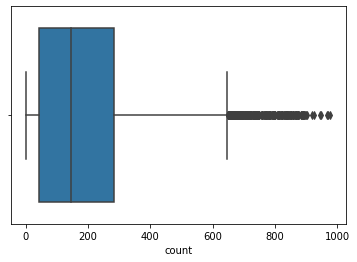

In [6]:
sns.distplot(train['count'])
plt.show()
sns.boxplot(train['count'])
plt.show()

In [7]:
# removing the outliers
print(train.shape)
train = train[abs(train['count'] - train['count'].mean()) < (3* np.std(train['count']))]
print(train.shape)


(10886, 15)
(10739, 15)


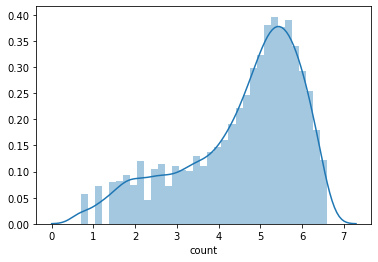

In [8]:
#Apply log transformation to create normal distribution
train['count'] = np.log(train['count']+1)
sns.distplot(train['count'])

---
## Correlation, collinearity, and exploring each variable

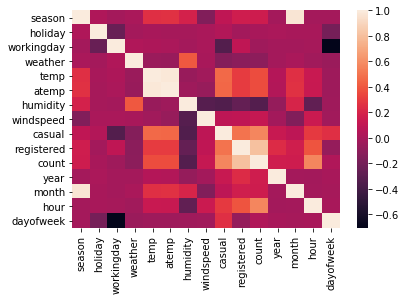

In [9]:
sns.heatmap(train.corr())

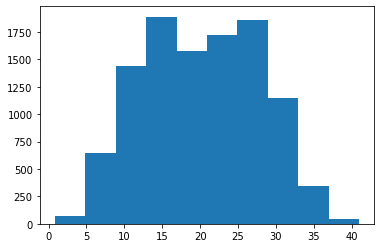

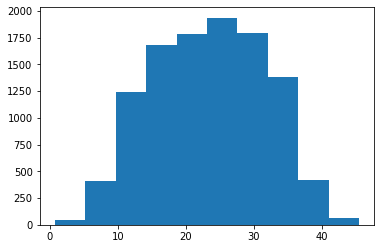

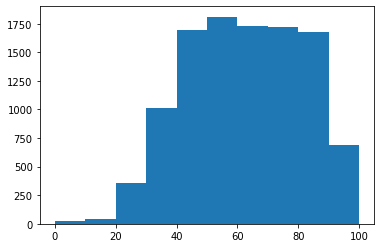

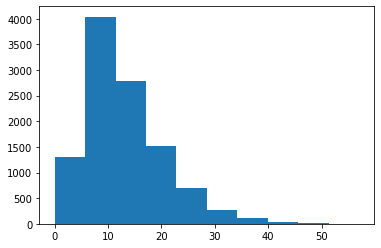

In [10]:
continuous= ['temp', 'atemp', 'humidity', 'windspeed']

for feat in continuous:
    plt.hist(train[feat])
    plt.show()

---
## Feature Engineering 


In [11]:
# handle wind
zero_wind = train[train['windspeed']==0].index
zero_wind
train['windspeed']=np.where(train['windspeed']==0, 5, train['windspeed'])

In [12]:
#create year+season

train['year_season'] = (train['year']) +(train['season'] / 10)
train.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek,year_season
0,1,0,0,1,9.84,14.395,81,5.0,3,13,2.833213,2011,1,0,5,2011.1
1,1,0,0,1,9.02,13.635,80,5.0,8,32,3.713572,2011,1,1,5,2011.1
2,1,0,0,1,9.02,13.635,80,5.0,5,27,3.496508,2011,1,2,5,2011.1


In [13]:
#delete columns that provide duplicate data

train = train.drop(columns= ['season', 'year', 'casual', 'registered'])


In [14]:
# create dummies
cats = ['weather', 'year_season', 'month', 'hour', 'dayofweek']
for val in cats:
    new = pd.get_dummies(train[val], prefix=val)
    train = pd.concat([train,new], axis=1)
train.drop(columns=cats, inplace=True)
train

,holiday,workingday,temp,atemp,humidity,windspeed,count,weather_1,weather_2,weather_3,weather_4,year_season_2011.1,year_season_2011.2,year_season_2011.3,year_season_2011.4,year_season_2012.1,year_season_2012.2,year_season_2012.3,year_season_2012.4,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,0,0,9.84,14.395,81,5.0000,2.833213,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,9.02,13.635,80,5.0000,3.713572,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,9.02,13.635,80,5.0000,3.496508,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,9.84,14.395,75,5.0000,2.639057,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,9.84,14.395,75,5.0000,0.693147,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,0,1,15.58,19.695,50,26.0027,5.820083,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
10882,0,1,14.76,17.425,57,15.0013,5.488938,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
10883,0,1,13.94,15.910,61,15.0013,5.129899,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
10884,0,1,13.94,17.425,61,6.0032,4.867534,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [15]:
train['true_temp'] = train['temp']+train['atemp'] / 2
train=train.drop(columns=['temp', 'atemp'])

In [16]:
#normalize wind, humidity, true_temp

for feat in ['humidity', 'windspeed', 'true_temp']:
    train[feat] = (train[feat] - train[feat].min())  /  (train[feat].max() - train[feat].min())
train.head(3)

,holiday,workingday,humidity,windspeed,count,weather_1,weather_2,weather_3,weather_4,year_season_2011.1,year_season_2011.2,year_season_2011.3,year_season_2011.4,year_season_2012.1,year_season_2012.2,year_season_2012.3,year_season_2012.4,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,true_temp
0,0,0,0.81,0.0,2.833213,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.257982
1,0,0,0.80,0.0,3.713572,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.238435
2,0,0,0.80,0.0,3.496508,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.238435


---
## Applying the same transformations to holdout data

In [17]:
#data variables
date = pd.DatetimeIndex(holdout['datetime'])
holdout['year'], holdout['month'], holdout['hour'], holdout['dayofweek'] = date.year, date.month, date.hour, date.dayofweek
holdout.drop(columns='datetime', inplace=True)

#wind
zero_wind = holdout[holdout['windspeed']==0].index
holdout['windspeed']=np.where(holdout['windspeed']==0, 5, holdout['windspeed'])
holdout

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,hour,dayofweek
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,0,3
1,1,0,1,1,10.66,13.635,56,5.0000,2011,1,1,3
2,1,0,1,1,10.66,13.635,56,5.0000,2011,1,2,3
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,1,0,1,2,10.66,12.880,60,11.0014,2012,12,19,0
6489,1,0,1,2,10.66,12.880,60,11.0014,2012,12,20,0
6490,1,0,1,1,10.66,12.880,60,11.0014,2012,12,21,0
6491,1,0,1,1,10.66,13.635,56,8.9981,2012,12,22,0


In [18]:
#new col
holdout['year_season'] = (holdout['year']) +(holdout['season'] / 10)
holdout.head(3)


#drop cols
holdout = holdout.drop(columns= ['season', 'year'])

#dums
cats = ['weather', 'year_season', 'month', 'hour', 'dayofweek']
for val in cats:
    new = pd.get_dummies(holdout[val], prefix=val)
    holdout = pd.concat([holdout,new], axis=1)
holdout.drop(columns=cats, inplace=True)


#true temp
holdout['true_temp'] = holdout['temp']+holdout['atemp'] / 2
holdout= holdout.drop(columns=['temp', 'atemp'])

#normalize
for feat in ['humidity', 'windspeed', 'true_temp']:
    holdout[feat] = (holdout[feat] - holdout[feat].min())  /  (holdout[feat].max() - holdout[feat].min())
holdout.head(3)

,holiday,workingday,humidity,windspeed,weather_1,weather_2,weather_3,weather_4,year_season_2011.1,year_season_2011.2,year_season_2011.3,year_season_2011.4,year_season_2012.1,year_season_2012.2,year_season_2012.3,year_season_2012.4,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,true_temp
0,0,1,0.47619,0.411829,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.244295
1,0,1,0.47619,0.000000,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.262158
2,0,1,0.47619,0.000000,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.262158


---
## Modelling
- I will use both random forests and xgboostregressor seperately
- If both perform well I will use weighted predictions to incorporate both into a single predictiona and resubmit

In [19]:
feats = train.drop(columns='count').columns

models = [{
            "name": "RandomForestRegressor",
            "estimator": RandomForestRegressor(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [100],
                    "max_depth": [20,50,80],
                    "min_samples_split": [2, 4]

                }
         },
    {
            "name": "GradientBoostingRegressor",
            "estimator": GradientBoostingRegressor(random_state=1),
            "hyperparameters":
                {
                    'min_samples_split':[1.0,2,3],
                    'min_samples_leaf':[2,3,5]

                }
        }]
            
for model in models:
    grid = GridSearchCV(model['estimator'], param_grid=model['hyperparameters'], scoring='neg_mean_squared_log_error')
    grid.fit(train[feats], train['count'])
    print(grid.best_params_)
    print(grid.best_score_)
    print(grid.best_estimator_)
    print('-----------')

{'max_depth': 50, 'min_samples_split': 4, 'n_estimators': 100}
-0.015225402767885005
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)
-----------
{'min_samples_leaf': 2, 'min_samples_split': 2}
-0.019452160754432176
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_l

In [20]:
model1= RandomForestRegressor(max_depth=50, min_samples_split= 4, n_estimators= 500).fit(train[feats], train['count'])
model2= GradientBoostingRegressor(min_samples_leaf=2, min_samples_split=2, n_estimators=500).fit(train[feats], train['count'])

In [21]:
predictions1 = pd.DataFrame(np.exp(model1.predict(holdout[feats]))+1)
predictions2 = pd.DataFrame(np.exp(model2.predict(holdout[feats]))+1)
predictions1

,0
0,10.949183
1,6.431432
2,4.898406
3,5.069721
4,3.979159
...,...
6488,219.361007
6489,155.495881
6490,118.298802
6491,93.631500


In [22]:
holdoutc1 = holdout.copy()
holdoutc2 = holdout.copy()

,0
0,12.402710
1,6.633179
2,4.984744
3,4.087225
4,3.731404
...,...
6488,158.625241
6489,118.213373
6490,98.759192
6491,77.404590


In [24]:
submission1 = pd.concat([dt, predictions1], axis=1)
submission1.columns=['datetime', 'count']

In [25]:
submission1.to_csv('submission1RF.csv', index=False)

In [27]:
submission2 = pd.concat([dt, predictions2], axis=1)
submission2.columns=['datetime', 'count']
submission2.to_csv('submission2RF.csv', index=False)

## 
I found that the RandomForests performed significantly better so I dont expect that combining predictions will result in better results. My RMSLE of .41 was in the top ten percent. 